In [1]:
# Import all required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace
plt.style.use(["science", "ieee"])
from gic.model.oml import OceanModel
from gic.model.cables import Cable, TheoriticalSolver

In [2]:
%matplotlib inline
# Synthetic B-field plot
Bt = pd.read_csv("tmp/out/001/Bt_syn.csv")
Bt.head()

,X,dTime
0,-0.000000e+00,0
1,-2.969900e-07,1
2,-1.157880e-06,2
3,-2.538300e-06,3
4,-4.394900e-06,4


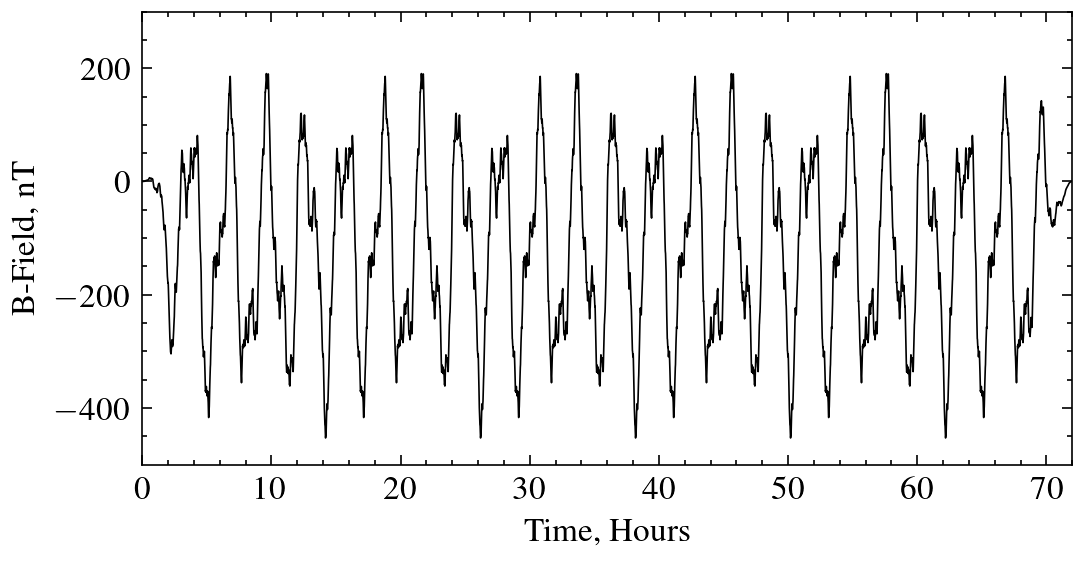

In [3]:
fig = plt.figure(dpi=240, figsize=(5,2.5))
ax = fig.add_subplot(111)
ax.plot(Bt.dTime / 3600.0, Bt.X, ls="-", lw=0.5)
ax.set_xlabel("Time, Hours")
ax.set_ylabel("B-Field, nT")
ax.set_xlim(0, 72)
_ = ax.set_ylim(-500, 300)

In [4]:
# Generate synthetic Ocean-Earth Model
thikness = np.array([4,2,10,140,254,250,340])*1e3
resistivity = np.array([0.3,3,3000,1000,100,10,1])
om = OceanModel(thikness, resistivity, flim=[1e-6,1e-2])
Tx = om.get_TFs()

2022-06-06 15:39:37.955 | INFO     | gic.model.oml:__init__:46 - Compile OM[] to calc O(floor) E- and B-Fields


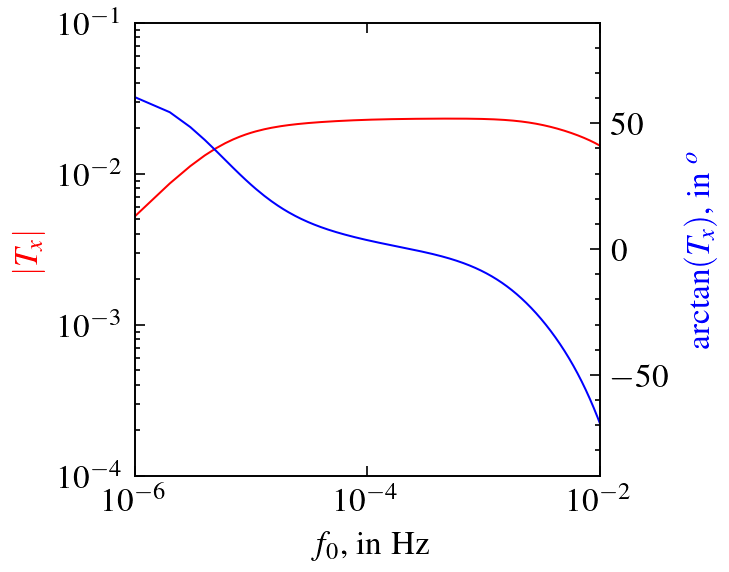

In [5]:
fig = plt.figure(dpi=240, figsize=(2.5,2.5))
ax = fig.add_subplot(111)
ax.loglog(Tx.freq, np.abs(Tx.E2B), "r", lw=0.6, ls="-")
ax.set_xlabel(r"$f_0$, in Hz")
ax.set_ylabel(r"$|T_x|$", color="r")
ax.set_xlim(1e-6,1e-2)
ax.set_ylim(1e-4,1e-1)
ax = ax.twinx()
ax.semilogx(Tx.freq, np.angle(Tx.E2B, deg=True), "b", lw=0.6, ls="-")
ax.set_ylabel(r"$\arctan(T_x)$, in $^o$", color="b")
ax.set_ylim(-90, 90)
_ = ax.set_xlim(1e-6,1e-2)

In [6]:
from gic.model.utils import RecursiveNamespace

2022-06-06 15:39:38.633 | WARNING  | gic.model.cables:setup:400 - Into cable setup section
2022-06-06 15:39:38.647 | INFO     | gic.model.cables:compute_lengths:130 - Cable length from directed length
2022-06-06 15:39:38.648 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-06-06 15:39:38.649 | INFO     | gic.model.cables:compile_oml:221 - Synthetic 670c8dbe-e5d0-11ec-8caf-7900202b10e7 FT1->OM(FT1)
2022-06-06 15:39:38.649 | INFO     | gic.model.cables:calc_trasmission_line_parameters:248 - Cable width: 1.0
2022-06-06 15:39:38.652 | INFO     | gic.model.cables:__init__:531 - In nodal analysis for 2 nodes
2022-06-06 15:39:38.653 | INFO     | gic.model.cables:equivalent_nodel_analysis:544 - Eq. nodal analysis.
2022-06-06 15:39:38.653 | INFO     | gic.model.cables:equivalent_nodel_analysis:547 - Node:0
2022-06-06 15:39:38.654 | INFO     | gic.model.cables:equivalent_nodel_analysis:547 - Node:1
2022-06-06 15:39:38.654 | INFO     | gic.model.cable

Z: 7.14$\times 10^{-5}$ (Ohm/m)
Y: 5.88$\times 10^{-9}$ (S/m)
Z0: 1.10$\times 10^{2}$ (Ohm)
gma: 6.48$\times 10^{-7}$ (/m)
Ad: 1.54$\times 10^{6}$ (m)


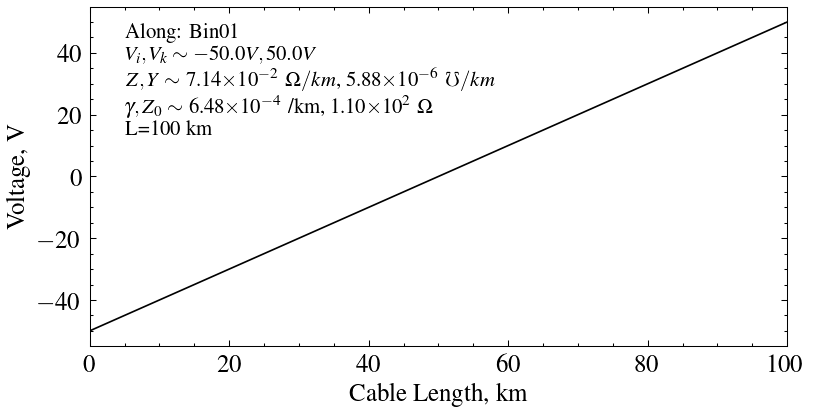

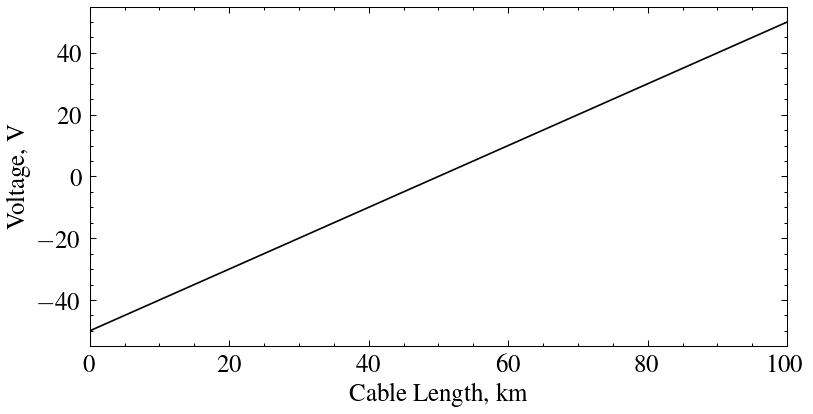

In [7]:
e = pd.DataFrame()
e["X"], e["dTime"] = [1], [0] # inputs is in mV/km
Efields = dict(
    syn = e
)
cab = {
    "cable_sections": [
        {
            "sec_id": 0,
            "directed_length": {
                "ln": 100.
            },
            "elec_params":{
                "earth_model": "FT1",
                "ocean_depth": 4000,
                "ocean_resistivity": 0.3
            }
        }
    ],
    "cable_pot_plot_index": 0
}
cable = RecursiveNamespace(**cab)
txcable = Cable(cable, Efields, None, ["X"], "tmp/out/002/")
print(txcable.tx_lines[0].return_properties())
txcable.run_nodal_analysis()

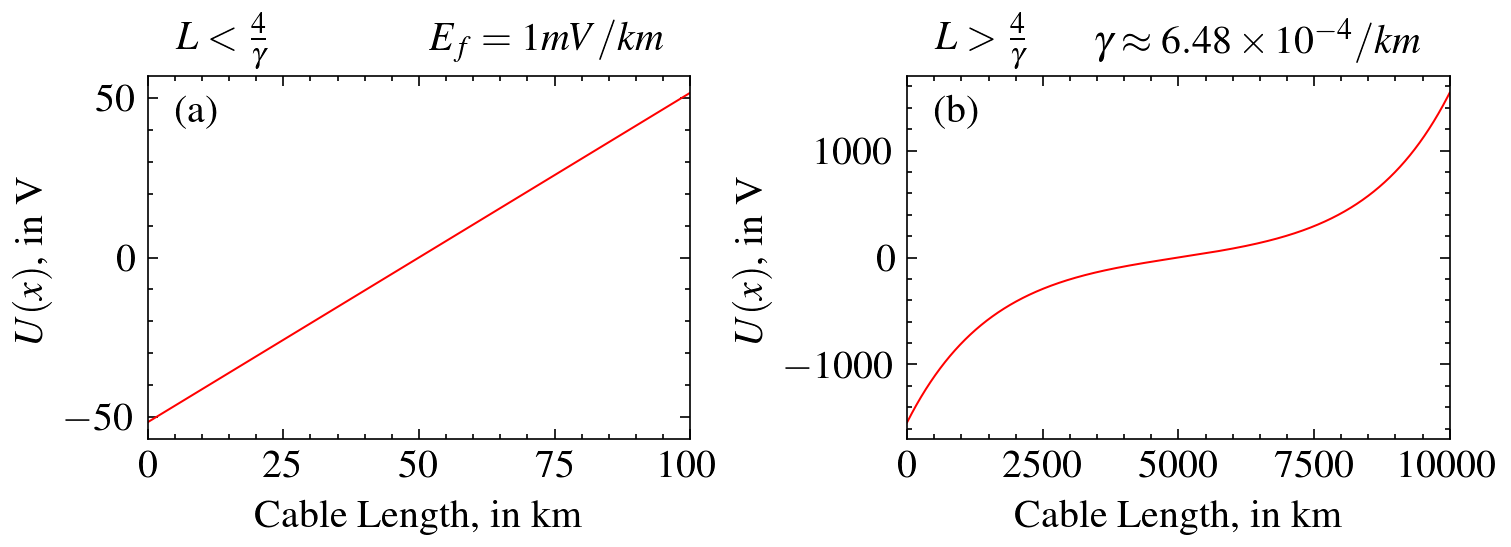

In [8]:
# Short Cable
ths = TheoriticalSolver(6.48e-4, 100., 1.0)
xs, Uxs = ths.calculate_electrically_short()
thl = TheoriticalSolver(6.48e-4, 10000., 1.0)
xl, Uxl = thl.calculate_electrically_long()
fig = plt.figure(dpi=240, figsize=(7,2))
ax = fig.add_subplot(121)
ax.plot(xs, Uxs, "r", lw=0.6, ls="-")
ax.set_xlabel(r"Cable Length, in km")
ax.text(0.05, 1.1, r"$L<\frac{4}{\gamma}$", ha="left", va="center", transform=ax.transAxes)
ax.text(0.95, 1.1, r"$E_f=1 mV/km$", ha="right", va="center", transform=ax.transAxes)
ax.set_ylabel(r"$U(x)$, in V")
ax.text(0.05, 0.9, "(a)", ha="left", va="center", transform=ax.transAxes)
ax.set_xlim(0,100)
#ax.set_ylim(-0.15,0.15)
ax = fig.add_subplot(122)
ax.plot(xl, Uxl, "r", lw=0.6, ls="-")
ax.set_xlabel(r"Cable Length, in km")
ax.set_ylabel(r"$U(x)$, in V")
ax.set_xlim(0,10000)
#ax.set_ylim(-1.6,1.6)
ax.text(0.05, 1.1, r"$L>\frac{4}{\gamma}$", ha="left", va="center", transform=ax.transAxes)
ax.text(0.95, 1.1, r"$\gamma\approx 6.48\times 10^{-4}/km$", ha="right", va="center", transform=ax.transAxes)
ax.text(0.05, 0.9, "(b)", ha="left", va="center", transform=ax.transAxes)
fig.subplots_adjust(wspace=0.4)

In [9]:
gmL = 0.01
print(np.exp(gmL), np.exp(-gmL))

1.010050167084168 0.9900498337491681
